# Linear regression with unknown uncertainties


We'll follow "Linear regression in astronomy" by Isobe et al., 1990 ([see bibliography.bib](https://github.com/astroJeff/SMAC/blob/master/bibliography.bib)).

Linear regression when only ($x_i$,$y_i$) are known. 

![title](img/Isobe_fig1.png)

Let ($x_i$,$y_i$), $i=1,...,n$ be independent, identically distributed observations from a population with mean ($\mu_x$,$\mu_y$) and covariance matrix:
$$
S=
  \begin{bmatrix}
    \sigma^2_x              & \rho \sigma_x \sigma_y \\
    \rho \sigma_x \sigma_y  & \sigma^2_y
  \end{bmatrix},
$$

where $\rho$ denotes the population correlation. Unlike most studies, normality will not be assumed here. Let
$$\bar{x} = \frac{1}{n} \sum\limits_{i=1}^{n} x_i,$$
$$\bar{y} = \frac{1}{n} \sum\limits_{i=1}^{n} y_i,$$
$$ S_{xx} = \sum\limits_{i=1}^{n} \left(x_i - \bar{x}\right)^2, $$
$$ S_{yy} = \sum\limits_{i=1}^{n} \left(y_i - \bar{y}\right)^2, $$
$$ S_{xy} = \sum\limits_{i=1}^{n}\left(x_i - \bar{x}\right) \left(y_i - \bar{y}\right),$$

then the slope and variance of the slope is defined as:

![title](img/Isobe_fig2.png)

Guidelines for the astronomer:
1. The five methods described here give regression coefficients that are theoretically different from each other, and are not five different estimates of the same quantity
+ Unless there is additional prior knowledge regarding the data (e.g., there are no horisintal residuals about the line) or the scientific question being asked (e.g., the goal is to predict new Y values from measured X values), there is no mathematical basis to prefer onw regressuon method over another
+ These methods address only data for which there is no understanding of the nature of the scatter about a linear relation. If the dispersion is principally due to the measurement process and is calculable, then weighted or "errors-in-variable" regression models should be used ([see Feigelson et al., 1992](https://github.com/astroJeff/SMAC/blob/master/bibliography.bib)). These methods concern cases where unknown variations within the objects under study cause the scatter.
+ Astronomers should first fit all five lines, each with its corresponding error analysis, to their data. If the differences between the lines are not greater than the errors on any one line, the choice of fitting method will not seriously affect the result. OLS(Y|X) is probably best in these cases, since it is widely known and understood.
+ If the scientific problem is such that one variable is clearly an "effect" and the other the "cause", then OLS(Y|X) should be used, where X is the causative variable. Similarly, if the probems is to predict the value of one variable from the measurement of another, then OLS(Y|X) should be used, where Y is the variable to be predicted. The latter situation is common in cosmic distance scale applications, where one wishes to predict the distance of an object from a linear regression fit generated from a sample with known distances.
+ If the goal is to estimate the underlying functional relation between the variables, as may apply when data are compared to astrophysical theory, then one of the regression lines treating the variables symmetrically should be used.  Based on the problems with the orthogonal regression and reduced major-axis methods discussed above, we recommend use of the OLS bisector.
+ Whatever method is adopted, we can unequivocally state that the derived regression coefficients should be accompanied by their appropriate error estimates.


In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.odr.odrpack import *
import sys


%matplotlib inline

In [36]:
# Stolen from https://github.com/sbird/spb_common/blob/master/leastsq.py
def leastsq(x,y, method=3):
    """
       Compute the least squares fit to y = beta x + alpha,
       using one of the 5 methods outlined in
       http://adsabs.harvard.edu/abs/1990ApJ...364..104Is
       Method 1 minimises distance from Y given X (ie, the standard least squares fit)
       Method 2 minimises distance from X given Y
       Method 3 (recommended) is the OLS bisector, which gives a line bisecting the above two.
       Method 4 (Orthogonal regression) minimises perpendicular distance from the line to points
       Method 5 is the geometric mean of the slopes from methods 1 and 2.
       Method 6 is the Theil-Sen estimator: the median of the pairwise slopes.
       (See Akritas 95,  http://www.tandfonline.com/doi/abs/10.1080/01621459.1995.10476499)
       Returns:
              (alpha, beta, bvar), the intercept slope and variance of the slope
    """
    #Define some sums
    xbar = np.mean(x)
    ybar = np.mean(y)
    xdif = x-xbar
    ydif = y-ybar
    sxx = np.sum(xdif**2)
    syy = np.sum(ydif**2)
    sxy = np.sum(ydif*xdif)

    #Check for zeros
    if sxx == 0 or syy == 0 or sxy == 0:
        raise ValueError("Least Squares ill-defined")
    if method > 6 or method < 1:
        raise ValueError("Method not recognised")

    #These formulas are taken from Table 1 of Isobe et al, page 3
    #Minimise distance from Y given X
    beta1 = sxy/sxx
    #Variance of b1
    bvar1 = np.sum(xdif**2*(ydif-beta1*xdif)**2)/sxx**2
    #Minimise distance from X given Y
    beta2 = syy/sxy
    #Variance of b2
    bvar2 = np.sum(ydif**2*(ydif-beta2*xdif)**2)/sxy**2
    #Covariance of b1 and b2
    covb12 = np.sum(xdif*ydif*(ydif-beta2*xdif)*(ydif-beta1*xdif))/(beta1*sxx**2)

    if method == 1:
        beta = beta1
        bvar = bvar1
    if method == 2:
        beta = beta2
        bvar = bvar2
    if method == 3:
        #OLS bisector: line that bisects the above two.
        beta1p1 = 1+beta1**2
        beta2p1 = 1+beta2**2
        beta = (beta1*beta2 - 1 + np.sqrt(beta1p1*beta2p1))/(beta1+beta2)
        #Variance
        prefac = beta**2 / ( (beta1 + beta2)**2 * beta1p1 * beta2p1)
        var = beta2p1**2 * bvar1 + 2 * beta1p1 * beta2p1 * covb12 + beta1p1**2 * bvar2
        bvar = prefac*var

    if method == 4:
        #Orthogonal: minimise perpendicular distance from line to points
        beta = 0.5*((beta2-1./beta1)+np.sign(sxy)*np.sqrt(4+(beta2-1./beta1)**2))
        prefac = beta**2 / (4*beta1**2 + (beta1*beta2 - 1)**2)
        bvar = prefac * ( bvar1/beta1**2 + 2*covb12 + beta1**2*bvar2 )

    if method == 5:
        #Reduced major axis:
        beta = np.sign(sxy)*np.sqrt(beta1*beta2)
        bvar = 0.25 * (beta2/beta1 * bvar1 + 2*covb12 + beta1/beta2 * bvar2)

    if method == 6:
        #Theil-Sen estimator for uncensored data: the median of the slopes.
        yy = np.subtract.outer(y,y)
        xx = np.subtract.outer(x,x)
        ind = np.where(xx != 0)
        beta = np.median(yy[ind]/xx[ind])
        #Can't find a formula for the variance
        bvar = 0

    #The intercept
    alpha = ybar - beta*xbar

    return (alpha, beta, bvar)

### Let's try all five on a set of data

###################  OLS(Y|X)  #######################
Slope = -4.61 ± 1.41
intercept = 57.75
###################  OLS(X|Y)  #######################
Slope = -13.81 ± 9.64
intercept = 78.15
###################  OLS bisector  #######################
Slope = -6.94 ± 1.45
intercept = 62.93
###################  ODR  #######################
Slope = -13.66 ± 9.40
intercept = 77.83
###################  RMA  #######################
Slope = -7.98 ± 1.09
intercept = 65.22


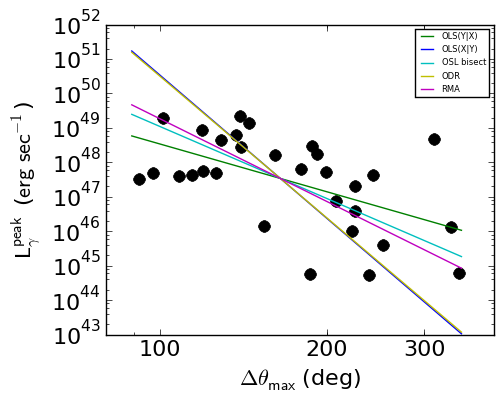

In [32]:
# Load up the data
amp_lum = np.loadtxt('Ampl_Lum.dat', comments='#')

rot_ampl = amp_lum[:,0]
lumin    = amp_lum[:,1]

# plotting
figure = plt.figure(figsize=(5.0, 4.0), dpi=150)
font = {'size'   : 16, 'family' : 'sans-serif'}
mpl.rc('font', **font)
figure.subplots_adjust(hspace=0.1)
fig1 = plt.subplot(111)

plt.errorbar(rot_ampl,lumin,xerr=0,yerr=0,color='k', marker='o', markeredgecolor='k',\
             ms=8., capsize=0, linestyle='None', fmt='')


# OLS(Y|X)
alpha, beta, bvar = leastsq(np.log10(rot_ampl),np.log10(lumin),method=1)
print("###################  OLS(Y|X)  #######################")
print("Slope = %.2f ± %.2f"%(beta,bvar))
print("intercept = %.2f"%(alpha))
x = np.linspace(89,350,100)
y = map(lambda m: 10**(beta * m + alpha), np.log10(x))
plt.plot(x,y,c='g',label='OLS(Y|X)')

# OLS(X|Y)
alpha, beta, bvar = leastsq(np.log10(rot_ampl),np.log10(lumin),method=2)
print "###################  OLS(X|Y)  #######################"
print("Slope = %.2f ± %.2f"%(beta,bvar))
print("intercept = %.2f"%(alpha))
x = np.linspace(89,350,100)
y = map(lambda m: 10**(beta * m + alpha), np.log10(x))
plt.plot(x,y,c='b',label='OLS(X|Y)')

# OLS bisector
alpha, beta, bvar = leastsq(np.log10(rot_ampl),np.log10(lumin),method=3)
print "###################  OLS bisector  #######################"
print("Slope = %.2f ± %.2f"%(beta,bvar))
print("intercept = %.2f"%(alpha))
x = np.linspace(89,350,100)
y = map(lambda m: 10**(beta * m + alpha), np.log10(x))
plt.plot(x,y,c='c',label='OSL bisect')

# ODR
# see also https://docs.scipy.org/doc/scipy/reference/odr.html
alpha, beta, bvar = leastsq(np.log10(rot_ampl),np.log10(lumin),method=4)
print "###################  ODR  #######################"
print("Slope = %.2f ± %.2f"%(beta,bvar))
print("intercept = %.2f"%(alpha))
x = np.linspace(89,350,100)
y = map(lambda m: 10**(beta * m + alpha), np.log10(x))
plt.plot(x,y,c='y',label='ODR')

# RMA
alpha, beta, bvar = leastsq(np.log10(rot_ampl),np.log10(lumin),method=5)
print "###################  RMA  #######################"
print("Slope = %.2f ± %.2f"%(beta,bvar))
print("intercept = %.2f"%(alpha))
x = np.linspace(89,350,100)
y = map(lambda m: 10**(beta * m + alpha), np.log10(x))
plt.plot(x,y,c='m',label='RMA')
plt.legend(prop={'size':6})


plt.xlabel(r'$\mathsf{\Delta \theta_{max}}$ (deg)')
plt.ylabel(r'$\mathsf{L_{\gamma}^{peak}}$ ($\mathsf{erg \, sec^{-1}}$)')

plt.xlim([80,400])
fig1.set_xscale('log')
fig1.set_yscale('log')
plt.xticks([100,200,300], ['100','200','300'])

plt.show()
plt.close()
plt.cla()
plt.clf()
